In [1]:
from glob import glob
import xarray as xr
import pandas as pd
import numpy as np

from scipy.special import gamma
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as mcolors

import snowScatt
from pytmatrix import tmatrix, tmatrix_aux, scatter, radar, refractive

from __prepare_hydrometeors import get_cloud_dsd, get_rain_dsd
from __prepare_hydrometeors import generate_rain_lookuptable
from __prepare_hydrometeors import get_rime_fraction_index # puts rime fraction into 0(<0 to 0.25) 1(0.25<=x<0.5) 2(0.5<=x<0.75) 3(0.75<x)
from __prepare_hydrometeors import get_rime_density_index # as before but 5 categories, plus it caps rime density
from __prepare_hydrometeors import calc_bulkRhoRime
from __prepare_hydrometeors import calc_threshold # my version vectorizable
from __prepare_hydrometeors import q2abs

from scattering_functions import tm_reflectivity
from scattering_functions import waves
from scattering_functions import scat_cloud, scat_rain, vector_liquid_Z
from scattering_functions import z_tm_solid_sphere, z_tm_BF95_spheroid

from microphysical_function import gammaPSD
from microphysical_function import vector_N, vector_q
from microphysical_function import Dice, Dcloud, Drain

import warnings
warnings.simplefilter("ignore")
import time
import sys
import os
import socket
from datetime import datetime as dt_module

# Different types of files:
# 2d_cldprcp (ncells, vertices, time), # 2d_cldprcp (ncells, vertices, time) -> 2d fields, strange dimensions
# basic__ (time, lon, lat, height) -> this seems the interesting one
# basic_zlev(time, lon, lat, alt) -> altitude? 93 alts instead of 150 heights???
# hlev_int50m_basic__ (time, lon, lat, height) -> again 93
iconP3path = '/data/optimice/P3paper_ICONoutput/P3realcase__20151124_624m_satad0/hlev_int50m_basic__DOM01_ML_20151124T090*Z.nc'
iconP3files = sorted(glob(iconP3path))

# Keep only the important variables
drops = ['u', 'v', 'w',
         #'temp',
         't_g', 'u_10m', 'v_10m',
         'qv', 'clc',
         #'qc', 'qi', 'qr', 'qirim', 'birim', 'qnc', 'qnr', 'qni',
         'p3eqv_refl', # keeping for comparison purposes
         'p3reff_cld', 'p3reff_ice', 'p3mw_vi', 'p3dmean_ice', 
         'p3rho_ice', # see if I can make use of it
         'p3ncnuc', 'p3qcnuc', 'p3ncheti', 'p3qcheti', 'p3nrheti', 'p3qrheti', 'p3ninuc', 'p3qinuc',
         'qccondiag', 'qrcondiag', 'dep_rate_ice', 'aggr_ice_n', 't_cbase', 'p_cbase', 't_ctop', 'p_ctop',
         #'rh',
         'temp_old',
         #'pres',
         # 'lamc', 'lamr', 'lami', 'mu_c', 'mu_r' # these Markus calculate himself, why?
        ]
# markusToKeep=["temp","pres","rh","qc","qi","qr","qnc","qni","qnr","qirim","birim"]

# Preprocessing of the data
def generate_preprocess(): # can take arguments
    # Generate a preprocess function that takes a dataset as only argument and does all the processing needed
    def preprocess(ds):
        # Convert strage YMD.fraction_of_the_day format into datetime64 (loss precision not important)
        ds['time'] = pd.to_datetime(ds.time.values.astype(int).astype(str), format='%Y%m%d') + pd.to_timedelta(ds.time.values%1, unit='D').round('1s')
        return ds
    return preprocess
iconP3data = xr.open_mfdataset(iconP3files,
                               concat_dim='time',
                               data_vars='minimal',
                               preprocess=generate_preprocess(), # drop_variables is called first
                               drop_variables=drops
                              ).isel(lat=0, lon=0).squeeze()
datetime = iconP3data.time.values
height = iconP3data.height.values

# To convert from specific to absolute quantities (take out hydrometeor occupied volume from the calculation of air density)
air_density = q2abs(1.0, iconP3data.temp, iconP3data.pres, iconP3data.rh, iconP3data.qc+iconP3data.qr+iconP3data.qi)

In [2]:
#%%timeit
# Compute DSDs parameters myself...
start = time.time()
generate_rain_lookuptable() #generate rain lookup-table at beginning 
mu_r_table = np.load('mu_r_table.npz') #just read the lookup-table
mu_r_table = mu_r_table['mu_r_table']
vector_cloud_dsd = np.vectorize(get_cloud_dsd, otypes=[np.float, np.float])
mu_c, lamc = vector_cloud_dsd(iconP3data.qc, iconP3data.qnc, iconP3data.pres, iconP3data.temp)
vector_rain_dsd = np.vectorize(get_rain_dsd, otypes=[np.float, np.float], excluded=['mu_r_table'])
mu_r, lamr = vector_rain_dsd(iconP3data.qr, iconP3data.qnr, iconP3data.pres, iconP3data.temp, mu_r_table=mu_r_table)
N0c = iconP3data.qnc*lamc**(mu_c+1.)/gamma(mu_c+1.)*air_density
N0r = iconP3data.qnr*lamr**(mu_r+1.)/gamma(mu_r+1.)*air_density
print('Compute liquid DSDs properties ', time.time()-start, ' seconds') # ~ 10 minutes# Calculate ice properties
start = time.time()
qi_tot = iconP3data.qi + iconP3data.qirim
rime_fraction = iconP3data.qirim/qi_tot.fillna(0.0)
vector_rime_fraction_index = np.vectorize(get_rime_fraction_index)
rime_frac_idx = vector_rime_fraction_index(rime_fraction.fillna(0.0))
vector_bulkRhoRime = np.vectorize(calc_bulkRhoRime)
rime_density = vector_bulkRhoRime(iconP3data.qirim, iconP3data.birim)
vector_rime_density_index = np.vectorize(get_rime_density_index)
rime_density, rime_dens_idx = vector_rime_density_index(rime_density)
vector_ice_PSD = np.vectorize(calc_threshold)
PSD = vector_ice_PSD(rime_dens_idx, rime_frac_idx, iconP3data.qni.fillna(0.0), qi_tot.fillna(0.0), rime_fraction.fillna(0.0), rime_density) # This executes for the whole day in 10 minutes. I guess I can speed up if I find a way to not load the vectors in memory
n_tot, mui, lami, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, _, _, _, _, _, _ = PSD
N0i = n_tot*lami**(mui+1.)/gamma(mui+1.)*air_density
print('Compute ice PSD properties ', time.time()-start, ' seconds') # ~ 10 minutes

Compute liquid DSDs properties  0.06499147415161133  seconds
Compute ice PSD properties  5.711093187332153  seconds


In [3]:
frequency_list = ['X', 'Ka', 'W']
#frequency_list = ['X']

frequency = xr.IndexVariable(dims='frequency', data=frequency_list, attrs={'unit':'frequency band label use pytmatrix for wavelength'})
coords = {'time':iconP3data.time,
          'height':iconP3data.height,
          'frequency':frequency}

11.834296226501465
Calculating liquid Z 1.6585204601287842 seconds
Calculating ice Z tm  7.743157148361206 seconds
Calculating ice Z ssrga  7.7864179611206055 seconds
Calculating ice Z dda  4.311296224594116 seconds
14.61254334449768
Calculating liquid Z 1.7216439247131348 seconds
Calculating ice Z tm  7.907301664352417 seconds
Calculating ice Z ssrga  7.857906103134155 seconds
Calculating ice Z dda  4.304903507232666 seconds
14.400055170059204
Calculating liquid Z 1.7158162593841553 seconds
Calculating ice Z tm  7.745156526565552 seconds
Calculating ice Z ssrga  7.7864439487457275 seconds
Calculating ice Z dda  4.316493034362793 seconds


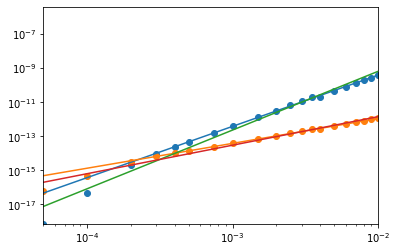

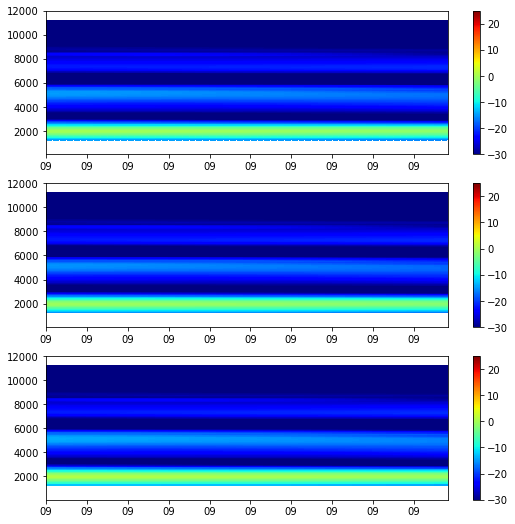

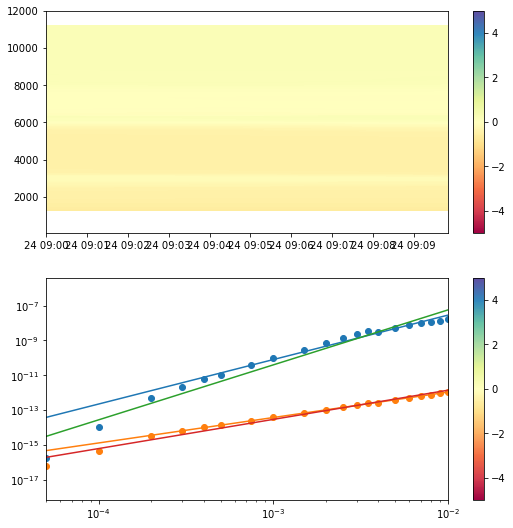

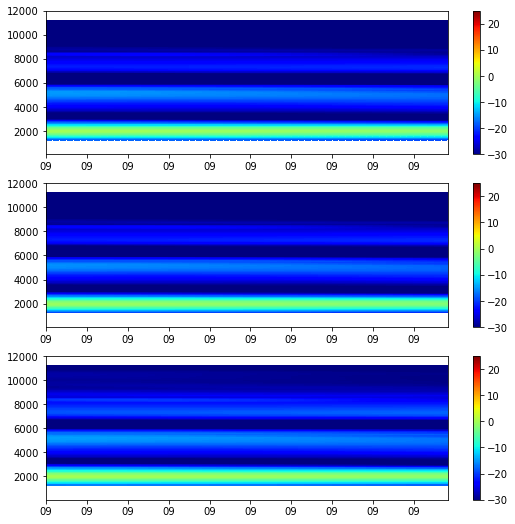

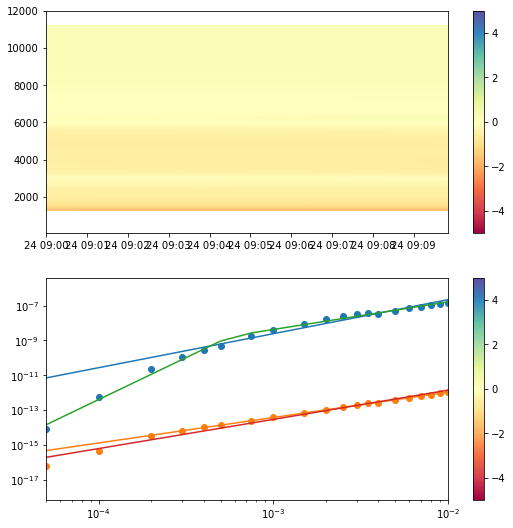

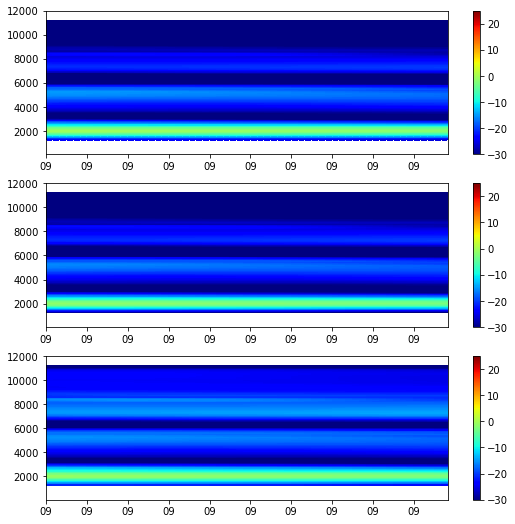

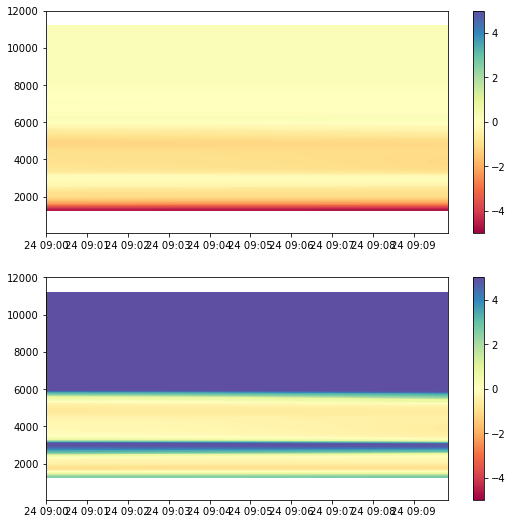

In [4]:
xrZssrga = xr.DataArray(dims=['time', 'height', 'frequency'], coords=coords, attrs={'long name':'Zice computed using ssrga for snow'})
xrZtm = xr.DataArray(dims=['time', 'height', 'frequency'], coords=coords, attrs={'long name':'Zice computed using TM for snow'})
xrZliu09 = xr.DataArray(dims=['time', 'height', 'frequency'], coords=coords, attrs={'long name':'Zice computed using Liu09 for snow'})
xrZliquid = xr.DataArray(dims=['time', 'height', 'frequency'], coords=coords, attrs={'long name':'Z of the liquid part'})

#################################################################################
# SCATTERING PART
#################################################################################
for freq_str in frequency.values:
    wl = waves[freq_str]
    n_water = refractive.m_w_0C[wl]
    rayleigh_coeff = wl**4/(tmatrix_aux.K_w_sqr[wl]*np.pi**5)
    wl *= 1.0e-3 # back to meters

    a_graupel = np.linspace(21, 472, 1000)
    a_partrimed = np.linspace(0.0121, 0.024, 1000)

    z_tm_graupel = pd.read_csv('z_tm_graupel_'+freq_str+'.csv', index_col=0, dtype=np.float64, engine='c')
    z_tm_graupel.columns = z_tm_graupel.columns.astype(np.float)
    z_tm_partrimed = pd.read_csv('z_tm_partrimed_'+freq_str+'.csv', index_col=0, dtype=np.float64, engine='c')
    z_tm_partrimed.columns = z_tm_partrimed.columns.astype(np.float)

    def iceP3tm_backscattering(dcrit, dcrits, dcritr):
        functions = [lambda x, ag, apr: np.nan,
                     lambda x, ag, apr: z_tm_solid_sphere.loc[x, freq_str],
                     lambda x, ag, apr: z_tm_BF95_spheroid.loc[x, freq_str],
                     lambda x, ag, apr: z_tm_graupel.iloc[z_tm_graupel.index.get_loc(ag, 'nearest')].loc[x],
                     lambda x, ag, apr: z_tm_partrimed.iloc[z_tm_partrimed.index.get_loc(apr, 'nearest')].loc[x]
                    ]
        def backscattering(D, ag, apr):
            conditions = [D<=0.0,
                          (0.0<D)*(D<=dcrit),
                          (dcrit<D)*(D<=dcrits),
                          (dcrits<D)*(D<=dcritr),
                          dcritr<D
                         ]
            return np.piecewise(D, conditions, functions, ag, apr)
        return backscattering

    def calc_ice_Z_tm(N0, mu, lam, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D):
        N = gammaPSD(N0, mu, lam)
        backscattering = iceP3tm_backscattering(dcrit, dcrits, dcritr)
        return (N(D)*backscattering(D, cgp, csr)*np.gradient(D)).sum()
    vector_ice_Z_tm = np.vectorize(calc_ice_Z_tm, excluded=['D'], otypes=[np.float])

    a_graupel = np.linspace(21, 472, 1000)
    a_partrimed = np.linspace(0.0121, 0.024, 1000)
    z_ssrga_partrimed = pd.DataFrame(index=a_partrimed, columns=Dice)
    start = time.time()
    z_ssrga_BF95 = pd.DataFrame(index=Dice, columns=['BF95'],
                                data=snowScatt.backscatter(Dice, wavelength=wl,
                                                           properties='Leinonen15tabA00', ref_index=refractive.mi(wl*1e3, 0.900),#temperature=270.0,
                                                           mass=np.minimum(0.0121*Dice**1.9, np.pi*900.0*0.6*Dice**3/6) # limit mass as in TM
                                                          )*1.0e6 # convert to mm2
                               )
    for j in a_partrimed:
        z_ssrga_partrimed.loc[j] = snowScatt.backscatter(Dice, wavelength=wl,
                                                         properties='Leinonen15tabA00', ref_index=refractive.mi(wl*1e3, 0.900),#temperature=270.0,
                                                         mass=np.minimum(j*Dice**1.9, np.pi*900.0*0.6*Dice**3/6) # limit mass as in TM
                                                        )*1.0e6 # pass from m2 to mm2
    print(time.time() - start )
    def iceP3ssrga_backscattering(dcrit, dcrits, dcritr):
        functions = [lambda x, ag, apr: np.nan,
                     lambda x, ag, apr: z_tm_solid_sphere.loc[x, freq_str],
                     lambda x, ag, apr: z_ssrga_BF95.loc[x, 'BF95'],
                     lambda x, ag, apr: z_tm_graupel.iloc[z_tm_graupel.index.get_loc(ag, 'nearest')].loc[x],
                     lambda x, ag, apr: z_ssrga_partrimed.iloc[z_ssrga_partrimed.index.get_loc(apr, 'nearest')].loc[x],
                    ]
        def backscattering(D, ag, apr):
            conditions = [D<=0.0,
                          (0.0<D)*(D<=dcrit),
                          (dcrit<D)*(D<=dcrits),
                          (dcrits<D)*(D<=dcritr),
                          dcritr<D
                         ]
            return np.piecewise(D, conditions, functions, ag, apr)
        return backscattering

    def calc_ice_Z_ssrga(N0, mu, lam, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D):
        N = gammaPSD(N0, mu, lam)
        backscattering = iceP3ssrga_backscattering(dcrit, dcrits, dcritr)
        return (N(D)*backscattering(D, cgp, csr)*np.gradient(D)).sum()
    vector_ice_Z_ssrga = np.vectorize(calc_ice_Z_ssrga, excluded=['D'], otypes=[np.float])

    def piecewise_linear(x, x0, y0, k1, k2):
        return np.piecewise(x, [x < x0], [lambda x:k1*x + y0-k1*x0, lambda x:k2*x + y0-k2*x0])
    RHfile = '/home/dori/develop/scatdb/share/scatdb.csv'
    dataRH = pd.read_csv(RHfile)
    dataRH = dataRH[dataRH.flaketype == 9] # sector snowflake
    #dataRH = dataRH[dataRH.flaketype == 20] # aggregate spherical
    #dataRH = dataRH[dataRH.flaketype == 21] # aggregate oblate
    #dataRH = dataRH[dataRH.flaketype == 22] # aggregate prolate
    dataRH = dataRH[abs(dataRH.temperaturek-270) < 4.9]
    dataRH = dataRH[abs(dataRH.frequencyghz-1.0e-9*snowScatt._compute._c/wl) < 0.5]
    dataRH['max_dimension'] = dataRH.max_dimension_mm*1.0e-3
    dataRH.set_index('max_dimension', inplace=True)
    dataRH.sort_index(inplace=True)
    dataRH['aeff'] = dataRH.aeffum*1.0e-6
    dataRH['mass'] = 4.0*np.pi*900.0*dataRH.aeff**3/3
    pm , em = curve_fit(piecewise_linear, np.log10(dataRH.index.values.astype(np.float)),
                                          np.log10(dataRH.mass.values.astype(np.float)))
    pc , ec = curve_fit(piecewise_linear, np.log10(dataRH.index.values.astype(np.float)),
                                          np.log10(dataRH.cbk.values.astype(np.float)))
    bm, am = np.polyfit(x=np.log10(dataRH.index.values.astype(np.float)[3:]),
                        y=np.log10(dataRH.mass.values.astype(np.float)[3:]),
                        deg=1)
    am = 10.0**am
    bc, ac = np.polyfit(x=np.log10(dataRH.index.values.astype(np.float)[3:]),
                        y=np.log10(dataRH.cbk.values.astype(np.float)[3:]),
                        deg=1)
    ac = 10.0**ac
    def dda_scattering(d):
        return am*d**bm, ac*d**bc
    def dda_scattering_piece(d):
        return 10**piecewise_linear(np.log10(d), *pm), 10**piecewise_linear(np.log10(d), *pc)
    mass_fit, bck_fit = dda_scattering(dataRH.index)
    mass_piece, bck_piece = dda_scattering_piece(dataRH.index)
    plt.scatter(dataRH.index, dataRH.cbk)
    plt.scatter(dataRH.index, dataRH.mass*1.0e-6)
    plt.plot(dataRH.index, bck_fit)
    plt.plot(dataRH.index, mass_fit*1e-6)
    plt.plot(dataRH.index, bck_piece)
    plt.plot(dataRH.index, mass_piece*1e-6)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim([0.00005, 0.01])
    plt.ylim([7e-19, 4e-6])

    def z_dda(d, m):
        mdda, bck = dda_scattering(d)
        return bck*1.0e6*(m/mdda)**2# convert to mm2 #*(m/mdda)**2

    def iceP3dda_backscattering(dcrit, dcrits, dcritr):
        functions = [lambda x, ag, apr: np.nan,
                     lambda x, ag, apr: z_tm_solid_sphere.loc[x, freq_str],
                     lambda x, ag, apr: z_dda(x, np.minimum(0.0121*x**1.9, np.pi*900.0*0.6*x**3/6)),
                     lambda x, ag, apr: z_tm_graupel.iloc[z_tm_graupel.index.get_loc(ag, 'nearest')].loc[x],
                     lambda x, ag, apr: z_dda(x, np.minimum(apr*x**1.9, np.pi*900.0*0.6*x**3/6)),
                    ]
        def backscattering(D, ag, apr):
            conditions = [D<=0.0,
                          (0.0<D)*(D<=dcrit),
                          (dcrit<D)*(D<=dcrits),
                          (dcrits<D)*(D<=dcritr),
                          dcritr<D
                         ]
            return np.piecewise(D, conditions, functions, ag, apr)
        return backscattering

    def calc_ice_Z_dda(N0, mu, lam, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D):
        N = gammaPSD(N0, mu, lam)
        backscattering = iceP3dda_backscattering(dcrit, dcrits, dcritr)
        return (N(D)*backscattering(D, cgp, csr)*np.gradient(D)).sum()
    vector_ice_Z_dda = np.vectorize(calc_ice_Z_dda, excluded=['D'], otypes=[np.float])

    start = time.time()
    Zcloud = vector_liquid_Z(N0c.values, mu_c, lamc, D=Dcloud, z=scat_cloud[freq_str].values)
    Zrain = vector_liquid_Z(N0r.values, mu_r, lamr, D=Drain, z=scat_rain[freq_str].values)
    print('Calculating liquid Z', time.time()-start, 'seconds') # less than 2 minutes for the liquid part, 
    start = time.time()
    ZiceTM = vector_ice_Z_tm(N0i.values, mui, lami, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D=Dice)
    print('Calculating ice Z tm ', time.time()-start, 'seconds') # less than 2 minutes for the liquid part, 
    start = time.time()
    ZiceSSRGA = vector_ice_Z_ssrga(N0i.values, mui, lami, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D=Dice)
    print('Calculating ice Z ssrga ', time.time()-start, 'seconds') # less than 2 minutes for the liquid part, 
    start = time.time()
    ZiceDDA = vector_ice_Z_dda(N0i.values, mui, lami, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D=Dice)
    print('Calculating ice Z dda ', time.time()-start, 'seconds') # less than 2 minutes for the liquid part,

    fig, axs = plt.subplots(3, 1, figsize=(9, 9))
    #mesh = axs[0].pcolormesh(datetime, height, iconP3data.p3eqv_refl.T, vmin=-30, vmax=25, cmap='jet')
    mesh = axs[0].pcolormesh(datetime, height, 10.0*np.log10(rayleigh_coeff*(Zrain.T+Zcloud.T+ZiceSSRGA.T)), vmin=-30, vmax=25, cmap='jet')
    plt.colorbar(mesh, ax=axs[0])
    mesh = axs[1].pcolormesh(datetime, height, 10.0*np.log10(rayleigh_coeff*(Zrain.T+Zcloud.T+ZiceTM.T)), vmin=-30, vmax=25, cmap='jet')
    plt.colorbar(mesh, ax=axs[1])
    mesh = axs[2].pcolormesh(datetime, height, 10.0*np.log10(rayleigh_coeff*(Zrain.T+Zcloud.T+ZiceDDA.T)), vmin=-30, vmax=25, cmap='jet')
    plt.colorbar(mesh, ax=axs[2])
    [a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
    fig.savefig('SSRGA_TM_Liu_'+freq_str+'.png')
    Zliquid = 10.0*np.log10(rayleigh_coeff*(Zrain+Zcloud))
    Zssrga = 10.0*np.log10(rayleigh_coeff*ZiceSSRGA)
    Ztm = 10.0*np.log10(rayleigh_coeff*ZiceTM)
    Zdda = 10.0*np.log10(rayleigh_coeff*ZiceDDA)
    xrZliquid.loc[dict(frequency=freq_str)] = Zliquid
    xrZssrga.loc[dict(frequency=freq_str)] = Zssrga
    xrZtm.loc[dict(frequency=freq_str)] = Ztm
    xrZliu09.loc[dict(frequency=freq_str)] = Zdda
    #np.savetxt('Zssrga'+freq_str+'.txt', Zssrga)
    #np.savetxt('Ztm'+freq_str+'.txt', Ztm)
    #np.savetxt('Zdda'+freq_str+'.txt', Zdda)
    
    fig, axs = plt.subplots(2, 1, figsize=(9, 9))
    mesh = axs[0].pcolormesh(datetime, height, Ztm.T-Zssrga.T,cmap='Spectral', vmin=-5, vmax=5 )
    plt.colorbar(mesh, ax=axs[0])
    mesh = axs[1].pcolormesh(datetime, height, Zdda.T-Zssrga.T, cmap='Spectral', vmin=-5, vmax=5)
    plt.colorbar(mesh, ax=axs[1])
    #[a.xaxis.set_major_formatter(mdates.DateFormatter('%H')) for a in axs.flatten()]
    fig.savefig('comp_'+freq_str+'.png')

In [5]:
scat_rain

,X,Ka,W
0.000001,2.31439e-22,5.29899e-20,2.01032e-18
0.000001,4.04447e-22,9.26014e-20,3.51309e-18
0.000001,7.06782e-22,1.61824e-19,6.13922e-18
0.000001,1.23512e-21,2.82791e-19,1.07285e-17
0.000001,2.15841e-21,4.94186e-19,1.87483e-17
...,...,...,...
0.006893,42.6127,20.1053,14.0333
0.007565,67.922,9.35908,12.0832
0.008302,105.081,26.1885,18.9757
0.009112,152.825,53.4507,21.4715


In [6]:
scat_cloud

,X,Ka,W
1.000000e-12,2.31439e-58,5.29899e-56,2.01032e-54
1.204504e-12,7.06782e-58,1.61823e-55,6.13922e-54
1.450829e-12,2.15841e-57,4.94186e-55,1.87483e-53
1.747528e-12,6.59147e-57,1.50917e-54,5.72545e-53
2.104904e-12,2.01294e-56,4.60879e-54,1.74847e-52
...,...,...,...
4.750810e-05,2.66087e-12,6.09269e-10,2.31208e-08
5.722368e-05,8.12574e-12,1.86064e-09,7.06169e-08
6.892612e-05,2.48141e-11,5.68221e-09,2.15694e-07
8.302176e-05,7.57755e-11,1.7353e-08,6.58871e-07


NameError: name 'z_tm_precomputed' is not defined

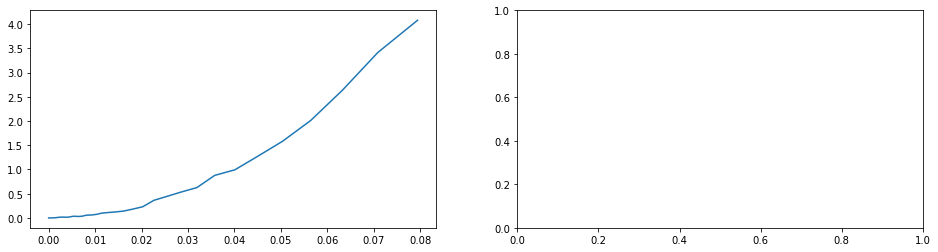

In [7]:
def iceP3tm_backscattering(dcrit, dcrits, dcritr):
    functions = [lambda x, ag, apr: np.nan,
                 lambda x, ag, apr: z_tm_precomputed.loc[x, 'solid'],
                 lambda x, ag, apr: z_tm_precomputed.loc[x, 'BF95'],
                 lambda x, ag, apr: z_tm_graupel.iloc[z_tm_graupel.index.get_loc(ag, 'nearest')].loc[x],
                 lambda x, ag, apr: z_tm_partrimed.iloc[z_tm_partrimed.index.get_loc(apr, 'nearest')].loc[x]
                ]
    def backscattering(D, ag, apr):
        conditions = [D<=0.0,
                      (0.0<D)*(D<=dcrit),
                      (dcrit<D)*(D<=dcrits),
                      (dcrits<D)*(D<=dcritr),
                      dcritr<D
                     ]
        return np.piecewise(D, conditions, functions, ag, apr)
    return backscattering

def calc_ice_Z_tm(N0, mu, lam, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D):
    N = gammaPSD(N0, mu, lam)
    backscattering = iceP3tm_backscattering(dcrit, dcrits, dcritr)
    return (N(D)*backscattering(D, cgp, csr)*np.gradient(D))

a_graupel = np.linspace(21, 472, 1000)
a_partrimed = np.linspace(0.0121, 0.024, 1000)
z_ssrga_partrimed = pd.DataFrame(index=a_partrimed, columns=Dice)
z_ssrga_BF95 = pd.DataFrame(index=Dice, columns=['BF95'],
                            data=snowScatt.backscatter(Dice, wavelength=wl,
                                                       properties='Leinonen15tabA00', ref_index=refractive.mi(wl*1e3, 0.900),#temperature=270.0,
                                                       mass=0.0121*Dice**1.9)*1.0e6 # convert to mm2
                           )
for j in a_partrimed:
    z_ssrga_partrimed.loc[j] = snowScatt.backscatter(Dice, wavelength=wl,
                                                     properties='Leinonen15tabA00', ref_index=refractive.mi(wl*1e3, 0.900),#temperature=270.0,
                                                     mass=j*Dice**1.9)*1.0e6 # pass from m2 to mm2
    
def iceP3ssrga_backscattering(dcrit, dcrits, dcritr):
    functions = [lambda x, ag, apr: np.nan,
                 lambda x, ag, apr: z_tm_precomputed.loc[x, 'solid'],
                 lambda x, ag, apr: z_ssrga_BF95.loc[x, 'BF95'],
                 lambda x, ag, apr: z_tm_graupel.iloc[z_tm_graupel.index.get_loc(ag, 'nearest')].loc[x],
                 lambda x, ag, apr: z_ssrga_partrimed.iloc[z_ssrga_partrimed.index.get_loc(apr, 'nearest')].loc[x],
                ]
    def backscattering(D, ag, apr):
        conditions = [D<=0.0,
                      (0.0<D)*(D<=dcrit),
                      (dcrit<D)*(D<=dcrits),
                      (dcrits<D)*(D<=dcritr),
                      dcritr<D
                     ]
        return np.piecewise(D, conditions, functions, ag, apr)
    return backscattering

def calc_ice_Z_ssrga(N0, mu, lam, dcrit, dcrits, dcritr, cs1, ds1, cs, ds, cgp, dg, csr, dsr, D):
    N = gammaPSD(N0, mu, lam)
    backscattering = iceP3ssrga_backscattering(dcrit, dcrits, dcritr)
    return (N(D)*backscattering(D, cgp, csr)*np.gradient(D))

fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].plot(z_ssrga_BF95.index, z_ssrga_BF95.BF95)
axs[0].plot(z_tm_precomputed.index, z_tm_precomputed.BF95)
axs[0].plot(Dice, z_dda(Dice, 0.0121*Dice**1.9))
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[1].plot(Dice, calc_ice_Z_ssrga(N0i[0, 19].values, mui[0, 19], lami[0, 19],
                                   dcrit[0, 19], dcrits[0, 19], dcritr[0, 19],
                                   cs1[0, 19], ds1[0, 19], cs[0, 19], ds[0, 19],
                                   cgp[0, 19], dg[0, 19], csr[0, 19], dsr[0, 19], Dice))
axs[1].plot(Dice, calc_ice_Z_tm(N0i[0, 19].values, mui[0, 19], lami[0, 19],
                                   dcrit[0, 19], dcrits[0, 19], dcritr[0, 19],
                                   cs1[0, 19], ds1[0, 19], cs[0, 19], ds[0, 19],
                                   cgp[0, 19], dg[0, 19], csr[0, 19], dsr[0, 19], Dice))
#axs[0].plot(Dice, z_dda(Dice, 0.0121*Dice**1.9))
axs[1].set_xscale('log')
axs[1].set_yscale('log')

In [ ]:
x = 0
y = 119
fig, axs = plt.subplots(1, 2, figsize=(16, 4))
axs[0].plot(z_ssrga_BF95.index, z_ssrga_BF95.BF95)
axs[0].plot(z_tm_precomputed.index, z_tm_precomputed.BF95)
axs[0].plot(Dice, z_dda(Dice, 0.0121*Dice**1.9))
axs[0].set_xscale('log')
axs[0].set_yscale('log')
ssrga_spec = calc_ice_Z_ssrga(N0i[x, y].values, mui[x, y], lami[x, y],
                              dcrit[x, y], dcrits[x, y], dcritr[x, y],
                              cs1[x, y], ds1[x, y], cs[x, y], ds[x, y],
                              cgp[x, y], dg[x, y], csr[x, y], dsr[x, y], Dice)
#axs[1].plot(Dice, ssrga_spec, marker='*')
tm_spec = calc_ice_Z_tm(N0i[x, y].values, mui[x, y], lami[x, y],
                        dcrit[x, y], dcrits[x, y], dcritr[x, y],
                        cs1[x, y], ds1[x, y], cs[x, y], ds[x, y],
                        cgp[x, y], dg[x, y], csr[x, y], dsr[x, y], Dice)
axs[1].plot(Dice, tm_spec-ssrga_spec, marker='.')
#axs[0].plot(Dice, z_dda(Dice, 0.0121*Dice**1.9))
axs[1].set_xscale('log')
axs[1].set_yscale('log')
#axs[1].set_ylim(1.0e-15, 1.0e-6)
print(dcrit[x, y], dcrits[x, y], dcritr[x, y])

In [ ]:
10.0*np.log10(tm_spec.sum())-10.0*np.log10(ssrga_spec.sum())

In [ ]:
snowScatt.refractiveIndex.ice.n(270, 94.0e9)

In [ ]:
 refractive.mi(wl*1e3, 0.910)

In [ ]:
snowScatt.backscatter(Dice, wavelength=wl, properties='Leinonen15tabA00', temperature=270.0, mass=0.0121*Dice**1.9)*1.0e6 # convert to mm2

In [ ]:
snowScatt.backscatter(Dice, wavelength=wl, properties='Leinonen15tabA00', ref_index=refractive.mi(wl*1e3, 0.900), mass=0.0121*Dice**1.9)*1.0e6 # convert to mm2

In [ ]:
variables = {'Ztm':xrZtm,
             'Zssrga':xrZssrga,
             'Zliu09':xrZliu09,
             'Zliquid':xrZliquid,
             'N0i':N0i,
             'N0r':N0r,
             'N0c':N0c,
             'lami':xr.DataArray(data=lami, dims=['time', 'height'], coords={'time':iconP3data.time, 'height':iconP3data.height}, attrs={'long_name':'lambda param ice PSD'}),
             'lamr':xr.DataArray(data=lamr, dims=['time', 'height'], coords={'time':iconP3data.time, 'height':iconP3data.height}, attrs={'long_name':'lambda param rain DSD'}),
             'lamc':xr.DataArray(data=lamc, dims=['time', 'height'], coords={'time':iconP3data.time, 'height':iconP3data.height}, attrs={'long_name':'lambda param cloud DSD'}),
             'mui': xr.DataArray(data=mui, dims=['time', 'height'], coords={'time':iconP3data.time, 'height':iconP3data.height}, attrs={'long_name':'mu param ice PSD'}),
             'mu_c': xr.DataArray(data=mu_c, dims=['time', 'height'], coords={'time':iconP3data.time, 'height':iconP3data.height}, attrs={'long_name':'mu param cloud DSD'}),
             'mu_r': xr.DataArray(data=mu_r, dims=['time', 'height'], coords={'time':iconP3data.time, 'height':iconP3data.height}, attrs={'long_name':'mu param rain DSD'}),
             #'dcrit':xr.DataArray(data=dcrit, dims=['time', 'height'], coords={'time':iconP3data.time, 'height':iconP3data.height}, attrs={'long_name':'mu param ice PSD'}),
             'dcrits':xr.DataArray(data=dcrits, dims=['time', 'height'], coords={'time':iconP3data.time, 'height':iconP3data.height}, attrs={'long_name':'P3 boundary snow-graupel'}),
             'dcritr':xr.DataArray(data=dcritr, dims=['time', 'height'], coords={'time':iconP3data.time, 'height':iconP3data.height}, attrs={'long_name':'P3 boundary graupel part-rimed'}),
             'cgp':xr.DataArray(data=cgp, dims=['time', 'height'], coords={'time':iconP3data.time, 'height':iconP3data.height}, attrs={'long_name':'prefactor graupel m-D'}),
             'csr':xr.DataArray(data=csr, dims=['time', 'height'], coords={'time':iconP3data.time, 'height':iconP3data.height}, attrs={'long_name':'prefactor part-rimed m_D'}),
            }

global_attributes = {'created_by':os.environ['USER'],
                     'host_machine':socket.gethostname(),
                     'created_on':str(dt_module.now()),
                     'comment':'this is just a test'}

dataset = xr.Dataset(data_vars=variables,
                     coords=coords,
                     attrs=global_attributes)

dataset.to_netcdf('fwdP3.nc')

In [ ]:
#mesh = plt.pcolormesh(datetime, height, iconP3data.p3rho_ice.T)
#mesh = plt.pcolormesh(datetime, height, rime_dens_idx.T)
#mesh = plt.pcolormesh(datetime, height, rime_frac_idx.T)
#mesh = plt.pcolormesh(datetime, height, qi_tot.T, vmax=0.0003)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qnc.T)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qnr.T)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qni.T, vmax= 350000)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qc.T)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qr.T, vmax=0.00001)
#mesh = plt.pcolormesh(datetime, height, iconP3data.qi.T, vmax=0.0002)
#mesh = plt.pcolormesh(datetime, height, rime_density.T)
#mesh = plt.pcolormesh(datetime, height, air_density.T)
#mesh = plt.pcolormesh(datetime, height, iconP3data.rh.T)
#plt.colorbar(mesh)

In [ ]:
#plt.pcolormesh(datetime, height, iconP3data.temp.T)
#plt.pcolormesh(datetime, height, iconP3data.p3eqv_refl.T)
#mesh = plt.pcolormesh(datetime, height, rime_density.T)
#mesh = plt.pcolormesh(datetime, height, n_tot.T)
#mesh = plt.pcolormesh(datetime, height, qc.T)
#mesh = plt.pcolormesh(datetime, height, qr.T, vmax=0.00001)
#mesh = plt.pcolormesh(datetime, height, qi.T, vmax=0.0002)
#mesh = plt.pcolormesh(datetime, height, Ni.T, vmax=350000)
#mesh = plt.pcolormesh(datetime, height, Nc.T)
#mesh = plt.pcolormesh(datetime, height, Nr.T)
#plt.colorbar(mesh)